In [1]:
import gEconpy as ge
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import sympy as sp

from cycler import cycler
from matplotlib.colors import Normalize

# Comparison of Production Functions

In this notebook, we compare the RBC model with a Cobb-Douglas (CD) and Constant Elasticity of Substitution (CES) production function. We will use many of the techniques from the {ref}`modeling primitives<model_primitives>` notebook, so reading that one first is recommended.

Here are the models we will be working with. Both are identical, save for the production function.

In [2]:
cd_gcn_path = "../GCN Files/RBC.gcn"
ces_gcn_path = "../GCN Files/RBC_with_CES.gcn"

In [3]:
ge.print_gcn_file(cd_gcn_path)

In [4]:
ge.print_gcn_file(ces_gcn_path)

In [5]:
mod_cd = ge.model_from_gcn(cd_gcn_path, backend="pytensor", mode="JAX", verbose=False)
mod_ces = ge.model_from_gcn(ces_gcn_path, backend="pytensor", mode="JAX", verbose=False)

## Show that the MRS is equal to $\psi$

As an exercise, we show that the marginal date of substitution between capital and labor in the CES case is equal to $\psi$, the elasticity parameter. 

All gEconpy models store sympy equations and variables which can be manipulated symbolically. In the next cells, we load the right-hand side of the production function (which happens to be equation 5, but I don't magically know that -- I checked them before writing this). Then we compure symbolic derivatives using the `.diff` method. 

The first two lines are a bit of python magic to transform all of the variables and parameters into python variables, so we can do code like `.diff(K)`. Otherwise, python doesn't know what "K" is refering to!

In [6]:
globals().update({x.base_name: x.to_ss() for x in mod_ces.variables})
globals().update({x.name: x for x in mod_ces.params})

# Compute derivatives of production function w.r.t inputs
production_fn = ge.utilities.eq_to_ss(mod_ces.equations[5].args[1])
display(production_fn)
dY_dK = production_fn.diff(K).simplify()
dY_dL = production_fn.diff(L).simplify()

display(sp.Eq(sp.Derivative(Y, K), dY_dK))
display(sp.Eq(sp.Derivative(Y, L), dY_dL))

A_ss*(alpha**(1/psi)*K_ss**((psi - 1*1)/psi) + L_ss**((psi - 1*1)/psi)*(1 - alpha)**(1/psi))**(psi/(psi - 1*1))

Eq(Derivative(Y_ss, K_ss), A_ss*(alpha/K_ss)**(1/psi)*(alpha**(1/psi)*K_ss**((psi - 1)/psi) + L_ss**((psi - 1)/psi)*(1 - alpha)**(1/psi))**(1/(psi - 1)))

Eq(Derivative(Y_ss, L_ss), A_ss*((1 - alpha)/L_ss)**(1/psi)*(alpha**(1/psi)*K_ss**((psi - 1)/psi) + L_ss**((psi - 1)/psi)*(1 - alpha)**(1/psi))**(1/(psi - 1)))

To find the elasticity of substituion, we use the condition that in an optimal allocation, all per-input cost marginal products of inputs should be equal. Define $Y_x = \frac{\partial Y}{\partial x}$ to lighten notation, then:

$$ 
\begin{align}
\frac{Y_K}{r_{ss}} &= \frac{Y_L}{w_{ss}} \implies \\
\frac{Y_K}{Y_L} &= \frac{r_{ss}}{w_{ss}} \\
\end{align}
$$

The marginal rate of substitution is defined as:

$$
\sigma = \frac{dV}{dZ} \frac{Z}{V}
$$

Where $V = \frac{K}{L}$ and $Z = \frac{w}{r}$

The next cell uses these definitions to show that $\sigma = \psi$

In [7]:
import sympy as sp

# At the optimum, we require dY/dK / r = dY/dL / w
w_res = sp.solve(dY_dK / r - dY_dL / w, w)[0]
ratio = w_res / r
display(sp.Eq(w / r, w_res / r))

V, Z, s = sp.symbols("V Z sigma", positive=True)
V_solved = sp.solve((w / r - ratio).subs({w / r: Z, K / L: V}), V)[0]
display(sp.Eq(K / L, V_solved.subs({Z: w / r})))

# Use indicator variables V, Z to compute MRS = dZ/dV * V / Z
display(sp.Eq(V, V_solved))
display(sp.Eq(sp.Derivative(V, Z), V_solved.diff(Z)))
display(sp.Eq(s, V_solved.diff(Z) * Z / V))
display(sp.Eq(s, (V_solved.diff(Z) * Z / V).subs({V: V_solved})))

Eq(w_ss/r_ss, (K_ss*(1 - alpha)/(alpha*L_ss))**(1/psi))

Eq(K_ss/L_ss, -alpha*(w_ss/r_ss)**psi/(alpha - 1))

Eq(V, -Z**psi*alpha/(alpha - 1))

Eq(Derivative(V, Z), -Z**psi*alpha*psi/(Z*(alpha - 1)))

Eq(sigma, -Z**psi*alpha*psi/(V*(alpha - 1)))

Eq(sigma, psi)

# Compare CES to Cobb Douglass

We can also use `sp.lambdify` to convert these sympy functions to executable python code. We'll do this to numerically show that Cobb-Douglass is a special case of CES, when $\psi = 1$.

First, extract the symbolic Cobb-Douglas production function 

In [8]:
cd_production_fn = mod_cd.equations[5].args[1]

Use `sp.lambdify` to convert the symbolic Cobb-Douglas function to a python function.

We have to add an adjustment factor of $\frac{(1 - \alpha)^{\alpha - 1}}{\alpha^\alpha}$, because the form of the CES function we're using here isn't the "standard" one. It includes a power on the factor use share parameter that makes the first order conditions nicer.

In [9]:
f_ces = sp.lambdify([psi, alpha, A, K, L], production_fn)
adjustment_factor = (1 - alpha) ** (alpha - 1) / alpha**alpha
f_cd = sp.lambdify(
    [alpha, A, K, L], ge.utilities.eq_to_ss(adjustment_factor * cd_production_fn)
)

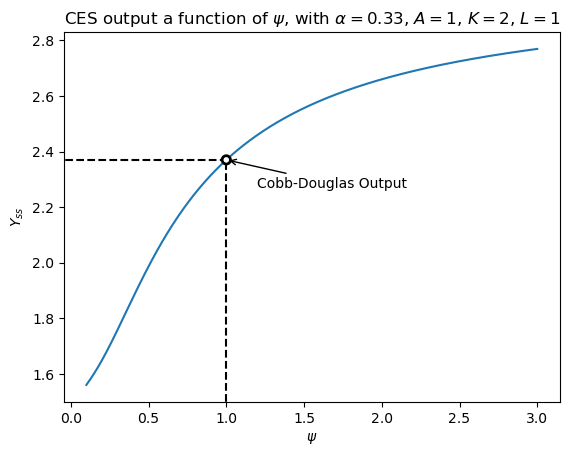

In [10]:
psi_grid = np.linspace(0.1, 3, 10000)
fig, ax = plt.subplots()
Y_ces = f_ces(psi_grid, 0.33, 1, 2, 1)

# plot the function in two parts, avoiding psi = 1
ax.plot(psi_grid[psi_grid < 0.97], Y_ces[psi_grid < 0.97], color="tab:blue")
ax.plot(psi_grid[psi_grid > 1.03], Y_ces[psi_grid > 1.03], color="tab:blue")

# Add a hole at psi = 1, using the output of the (adjusted) cobb-douglas
psi_one_output = f_cd(0.33, 1, 2, 1)
ax.scatter(1.0, psi_one_output, lw=2, facecolor="none", edgecolor="k", zorder=100)
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Make the lines from the axes to the circle, leaving some room to keep the circle empty
cd_output = f_cd(0.33, 1, 2, 1)
ax.vlines(1.0, ylims[0] - 0.5, cd_output - 0.01, ls="--", color="k")
ax.hlines(psi_one_output, -0.5, 0.98, ls="--", color="k")
ax.annotate(
    xy=(1.0, psi_one_output),
    xytext=(1.2, psi_one_output - 0.1),
    text="Cobb-Douglas Output",
    arrowprops={"arrowstyle": "->"},
)
ax.set(
    xlim=xlims,
    ylim=ylims,
    title=r"CES output a function of $\psi$, with $\alpha = 0.33$, $A = 1$, $K=2$, $L=1$",
    xlabel=r"$\psi$",
    ylabel=r"$Y_{ss}$",
)

plt.show()

# Maximum Value of $\psi$

One interesting thing about the CES function is that it introduces boundaries on model parameters. This is because of the steady state equation for $N_{ss}$, the steady-state capital-labor ratio. Here it is:

$$N_{ss} = \left ( \frac{\left ( \frac{1}{\beta} - (1 - \delta) \right ) ^{\psi - 1} \alpha ^ {\frac{1 - \psi}{\psi}}  (A_{ss} mc_{ss}) ^ {1 - \psi} - \alpha ^ {\frac{1}{\psi}}}{(1 - \alpha) ^ {\frac{1}{\psi}}} \right) ^ {\frac{\psi}{1 - \psi}}$$

For the steady-state to be economically meaningful, the capital-labor ratio needs to be strictly positive and real. Looking at this expression, though, there's a subtraction in the numerator. Thus, the inner term can be negative when:

$$\left ( \frac{1}{\beta} - (1 - \delta) \right ) ^{\psi - 1} \alpha ^ {\frac{1 - \psi}{\psi}}  (A_{ss} mc_{ss}) ^ {1 - \psi} \lt \alpha ^ {\frac{1}{\psi}} $$

$\frac{1}{\beta} - (1 - \delta)$ is aways going to be positive and close to zero for values of $\beta$ and $\delta$ we consider plausable ($\beta \approx 1$ and $\delta \approx 0$). $A_{ss} = 1$ almost always, and $\alpha$ and $mc_{ss}$ are positive. So the wrinkle really comes from the exponent, $\psi$.

It is an interesting exercise to set this equation to zero and solve for $\psi$:

In [11]:
psi_zero = sp.solve(
    sp.Eq(
        (1 / beta - (1 - delta)) ** (psi - 1) * alpha ** ((1 - psi) / psi),
        alpha ** (1 / psi),
    ),
    psi,
)[0]

In [12]:
psi_zero

(log(beta/alpha) - log(beta*delta - beta + 1))/(log(beta) - log(beta*delta - beta + 1))

This expression tells us, given parameters $\alpha$, $\beta$, and $\delta$, what is the value of $\psi$ such that the inequality above holds with equality. This gives a ceiling on allowable values of $\psi$. The next cell creates a graph to visualize the problem.

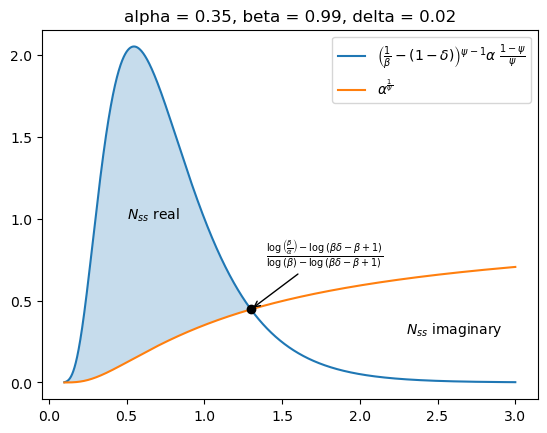

In [13]:
fig, ax = plt.subplots()
f1 = sp.lambdify(
    [alpha, beta, delta, psi],
    (1 / beta - (1 - delta)) ** (psi - 1) * alpha ** ((1 - psi) / psi),
)
f2 = sp.lambdify([alpha, psi], alpha ** (1 / psi))
f3 = sp.lambdify([alpha, beta, delta], psi_zero)


alpha_val = mod_ces.parameters()["alpha"]
beta_val = mod_ces.parameters()["beta"]
delta_val = mod_ces.parameters()["delta"]

p0 = f3(alpha_val, beta_val, delta_val)

lhs_val = f1(alpha_val, beta_val, delta_val, psi_grid)
rhs_val = f2(alpha_val, psi_grid)

ax.plot(
    psi_grid,
    lhs_val,
    label=r"$\left ( \frac{1}{\beta} - (1 - \delta) \right ) ^{\psi - 1} \alpha ^ {\frac{1 - \psi}{\psi}}$",
)
ax.plot(psi_grid, rhs_val, label=r"$\alpha^{\frac{1}{\psi}}$")

ax.scatter(p0, f2(alpha_val, p0), zorder=100, color="k")
ax.annotate(
    xy=(p0, f2(alpha_val, p0)),
    xytext=(p0 + 0.1, f2(alpha_val, p0) + 0.3),
    text="$" + sp.latex(psi_zero) + "$",
    arrowprops={"arrowstyle": "->"},
)

ax.fill_between(psi_grid, rhs_val, lhs_val, where=lhs_val > rhs_val, alpha=0.25)
ax.text(x=2.3, y=0.3, s=r"$N_{ss}$ imaginary")
ax.text(x=0.5, y=1.0, s=r"$N_{ss}$ real")

ax.legend()
ax.set_title(
    f"alpha = {alpha_val:0.2f}, beta = {beta_val:0.2f}, delta = {delta_val:0.2f}"
)
plt.show()

What is the effect on the boundary as $\alpha$, $\beta$, and $\delta$ change? Then next graph shows these effects, allowing one variable to change while holding the other two fixed.

We see that the boundary is decreasing in alpha and beta, and increasing in delta.

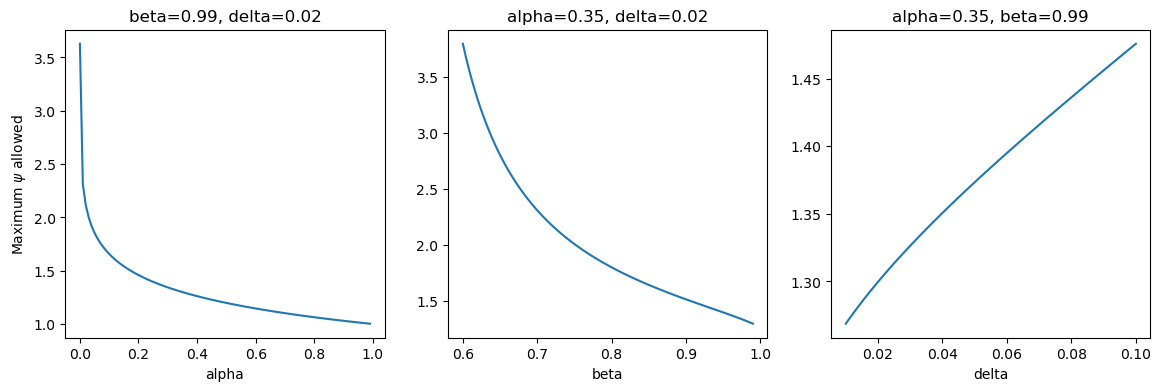

In [14]:
f = sp.lambdify([alpha, beta, delta], psi_zero)
alphas = np.linspace(1e-4, 0.99, 100)
betas = np.linspace(0.6, 0.99, 100)
deltas = np.linspace(0.01, 0.1, 100)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

names = ["alpha", "beta", "delta"]
x_values = [alpha_val, beta_val, delta_val]
grid_values = [alphas, betas, deltas]

for axis, var, values in zip(fig.axes, names, grid_values):
    input_dict = mod_ces.parameters().copy()
    input_dict[var] = values
    axis.plot(
        values,
        f(
            alpha=input_dict["alpha"],
            beta=input_dict["beta"],
            delta=input_dict["delta"],
        ),
    )
    axis.set(
        xlabel=var,
        title=", ".join(
            [f"{x}={val:0.2f}" for x, val in zip(names, x_values) if x != var]
        ),
    )
    if axis == fig.axes[0]:
        axis.set_ylabel(r"Maximum $\psi$ allowed")
plt.show()

Plotting these same boundaries in 3d (leaving out one variable at a time) shows a similar picture. Essentially, for parameterizations that are considered economically interesting, it is not possible to have $\psi$ much larger than 1.5.

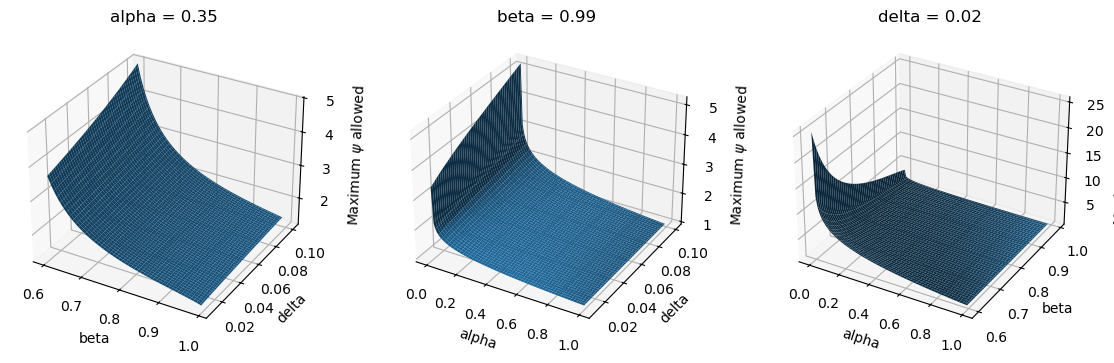

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), subplot_kw={"projection": "3d"})
var_dict = dict(zip(names, grid_values))

for axis, exlude_var in zip(fig.axes, names):
    to_plot = [var for var in names if var != exlude_var]

    x, y = map(var_dict.get, to_plot)
    xx, yy = np.meshgrid(x, y)

    input_dict = mod_ces.parameters().copy()
    input_dict.update(dict(zip(to_plot, [xx, yy])))
    Z = f(alpha=input_dict["alpha"], beta=input_dict["beta"], delta=input_dict["delta"])
    axis.plot_surface(xx, yy, Z)

    axis.set(
        xlabel=to_plot[0],
        ylabel=to_plot[1],
        zlabel=r"Maximum $\psi$ allowed",
        title=f"{exlude_var} = {input_dict[exlude_var]:0.2f}",
    )
plt.show()

# Admissible Isoquants

The purpose of including $\psi$ is to allow variation in the curvature of the isoquants trading off equivalent capital-labor bundles. In general:

- As $\psi \to 0$, we have perfect compliments (leontief case)
- As $\psi \to \infty$, we have perfect substitutes (linear case) 

To plot isoquants, we first symbolically solve the production function for one of the two inputs. I arbitrarily choose $K$.

In [16]:
Q = sp.solve(Y - production_fn, K)[0].simplify().subs({A: 1})
Q

(-L_ss**((psi - 1)/psi)*(1 - alpha)**(1/psi) + Y_ss**((psi - 1)/psi))**(psi/(psi - 1))/alpha**(1/(psi - 1))

In [17]:
cd2 = Y - adjustment_factor * K**alpha * L ** (1 - alpha)
Q_cd = sp.solve(cd2, K)[0].simplify()

Note that when $\psi < 1$, this has a vertical asymptote at $L_{ss} = Y_{ss}(1 - \alpha)^{\frac{1}{1 - \psi}}$, so we'll have to choose the grid to take that into account. We're not interested in values to the left of this asymptote.

In [18]:
psi_max = float(psi_zero.subs(mod_ces.parameters().to_sympy()))
psi_max

1.299675484840658

The next cell generates a plot showing what types of isoquants are possible, given $\alpha = 0.35$. Because $\psi$ is capped at 1.299, the isoquants cannot become arbitrarily linear. Still, values of $\psi$ close to the limit are already quite linear, so the function remains quite expressive. 

We *are* allow to arbitrarily lower $\psi$ towards zero, so inputs can become arbitrarily complimentary. 

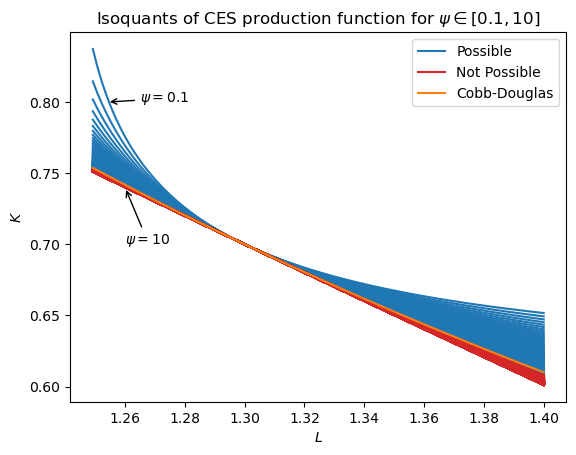

In [19]:
fig, ax = plt.subplots()

f_Q = sp.lambdify([alpha, psi, A, Y, L], Q)
f_Q_cd = sp.lambdify([alpha, A, Y, L], Q_cd)
f_min = sp.lambdify([alpha, psi, Y], Y * (1 - alpha) ** (1 / (1 - psi)))

L_min = f_min(alpha=alpha_val, psi=0.1, Y_ss=2.0)
L_grid = np.linspace(L_min + 0.01, 1.4, 100)

for psi_val in np.linspace(0.1, 10, 1000):
    K_grid = f_Q(alpha=alpha_val, psi=psi_val, A_ss=1.0, Y_ss=2.0, L_ss=L_grid)
    ax.plot(
        L_grid,
        K_grid,
        label=r"$\psi =$" + f"{psi_val:0.2f}",
        color="tab:blue" if psi_val < psi_max else "tab:red",
    )
lines = list(ax.get_lines())
ax.annotate(
    xy=(1.254, 0.8),
    xytext=(1.265, 0.8),
    text=r"$\psi=0.1$",
    arrowprops={"arrowstyle": "->"},
)
ax.annotate(
    xy=(1.26, 0.74),
    xytext=(1.26, 0.7),
    text=r"$\psi=10$",
    arrowprops={"arrowstyle": "->"},
)

(cd_line,) = ax.plot(
    L_grid,
    f_Q_cd(alpha=alpha_val, A_ss=1.0, Y_ss=2.0, L_ss=L_grid),
    color="tab:orange",
    label="Cobb-Douglas",
)

ax.legend([lines[0], lines[-1], cd_line], ["Possible", "Not Possible", "Cobb-Douglas"])
ax.set(
    title=r"Isoquants of CES production function for $\psi \in [0.1, 10]$",
    xlabel=r"$L$",
    ylabel=r"$K$",
)
plt.show()

# Effect of $\psi$ on the steady state

Varying $\psi$ and looking at steady state outputs, we see that as input factors become more interchangable -- as $\psi \to \infty$ -- steady state output increases, as does capital and investment. This is driven by the fact that steady-state wages are a function of $\psi$, whereas steady-state rental rates are not. Thus, as $\psi$ increases, labor gets more expensive relative to capital, *and* it becomes easier to substitute away from labor towards capital. Thus both effects facilitate the firm shifting aggressively into capital.

In [20]:
psis = np.linspace(0.1, 1.2, 50)
df = pd.DataFrame({psi: mod_ces.steady_state(psi=psi) for psi in psis}).T

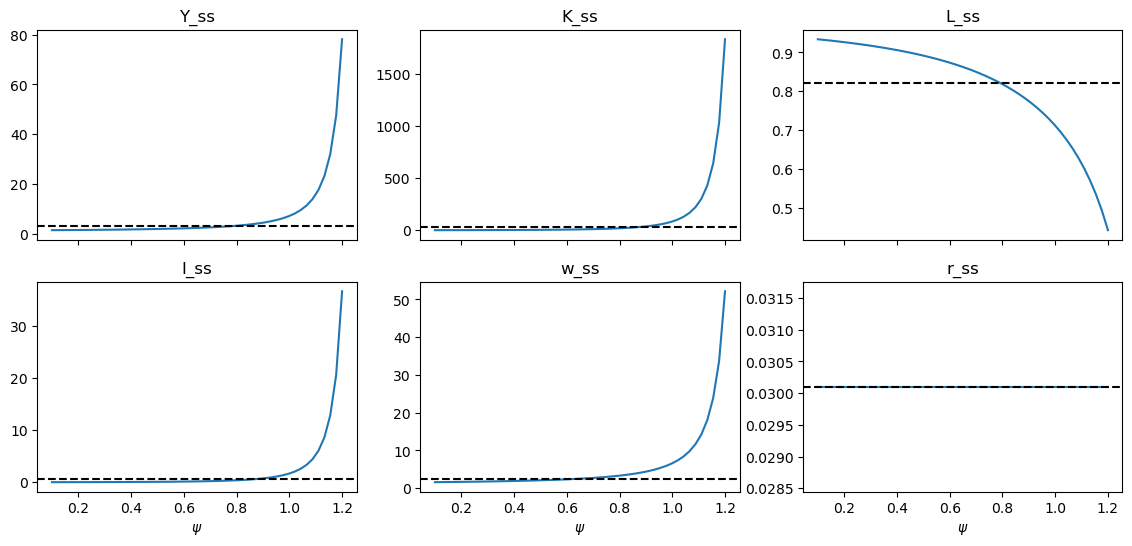

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
param_names = [x.name for x in mod_cd.params]
for axis, var in zip(fig.axes, ["Y_ss", "K_ss", "L_ss", "I_ss", "w_ss", "r_ss"]):
    df.plot.line(y=var, ax=axis, legend=False)
    axis.axhline(mod_cd.steady_state()[var], ls="--", c="k")
    axis.set(title=var, xlabel=r"$\psi$")

# Effect of $\psi$ on IRF

One final question is the effect on dynamics. This last plot looks at impulse response functions following a shock to total factor productivity for varying values of $\psi$.

As $\psi$ increases:

- Output reacts more strongly to the TFP shock, increasing more at $t=1$
- Wages react less strong to the TFP shock, increasing less at $t=1$

Effects on consumption, labor, and rental rates are more complex. When $\psi$ is extremely low (dark purple lines), the shock has a negative effect on labor and rental rates, while consumption increases, then decays monotonically. This is consistent with the observations about the effect of $\psi$ on the steady state: higher $\psi$ pushes up wages while also making it easier for firms to subsitute away from labor, towards capital. This pushes down labor demand and pushes up capital demand. Households respond by investing more, which increases capital supply and pushes down the price of capital. 

At some point, however, we see a regime switch. When $\psi$ is very high, labor and rental rates respond positively to the shock. Capital remains positive, but it gains a degree of persistance. Across the economy, the shock appears to persist longer when $\psi$ increases.

In [22]:
irfs = [
    ge.impulse_response_function(
        mod_ces, psi=psi, shock_size={"epsilon_A": 0.1}, verbose=False
    )
    for psi in psis
]
irfs = xr.concat(irfs, coords="all", dim="psi").assign_coords(psi=psis)

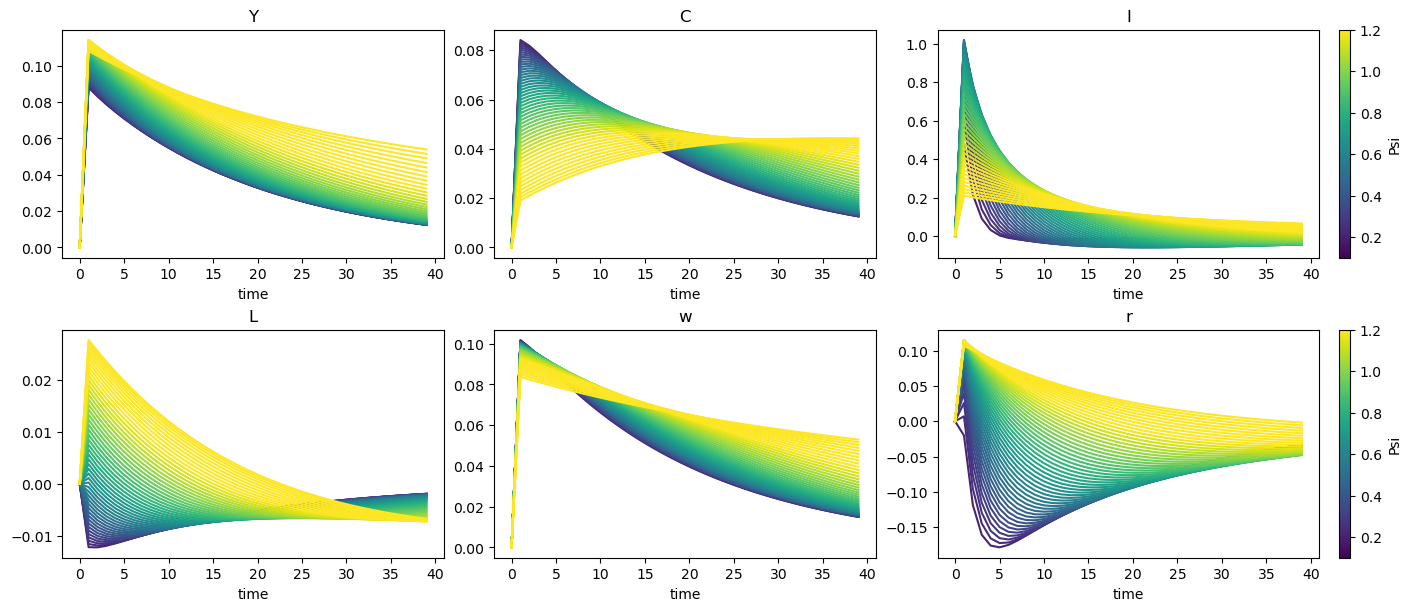

In [23]:
norm = Normalize(vmin=psis.min(), vmax=psis.max())
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(2, 3, figsize=(14, 6), layout="constrained")
for axis, variable in zip(fig.axes, ["Y", "C", "I", "L", "w", "r"]):
    axis.set_prop_cycle(cycler("color", [plt.colormaps["viridis"](i) for i in psis]))
    irfs.sel(variable=variable, shock="epsilon_A").plot.line(
        x="time", hue="psi", add_legend=False, ax=axis
    )
    axis.set_title(variable)

    if axis in ax[:, -1]:
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        cbar = fig.colorbar(sm, ax=axis)
        cbar.set_label("Psi")

plt.show()

The question of persistance can be more directly addressed by looking at partial autocorrelations. The {func}`autocorrelation_matrix` function will generate an autocorrelation tensor associated with the model, given a shock size. The next cell generates these tensors for a range of values of $\psi$. 

The autocorrelations will be the diagonal of the autocorrelaton matrix. {func}`autocorrelation_matrix` returns an xarray Dataset with dimensions `(variable, variable_aux, lag)`. To slice out the diagonal, we use `xarray_einstats`, which has a number of tools for working with xarrays.

In [24]:
from xarray_einstats.linalg import diagonal as xr_diagonal

vars_to_plot = ["Y", "C", "I", "L", "w", "r"]
acorr_mats = [
    xr_diagonal(
        (
            ge.autocorrelation_matrix(mod_ces, psi=psi, shock_std=0.1, verbose=False)
            .expand_dims("psi")
            .assign_coords({"psi": [psi]})
        ),
        dims=["variable", "variable_aux"],
    ).sel(variable=vars_to_plot)
    for psi in psis
]
acorr_mats = xr.concat(acorr_mats, dim="psi")

The following plot shows the autocorrelations for each variable, at each value of $\psi$. Lighter colors are associated with higher $\psi$ (e.g. more linear isoquants). For variables $Y$, $C$, $w$, and especially $I$, we see a pattern of higher persistance when $\psi$ is higher. For $r$, the pattern seems to reverse, which lower $\psi$ assoicated with more persistance (slower decay). 

The most complex store is in $L$, where we see a sort of U-shaped pattern. Persistance seems to first go up (it's getting darker from the middle to the top), then "loops around", becomes low, and starts increasing again

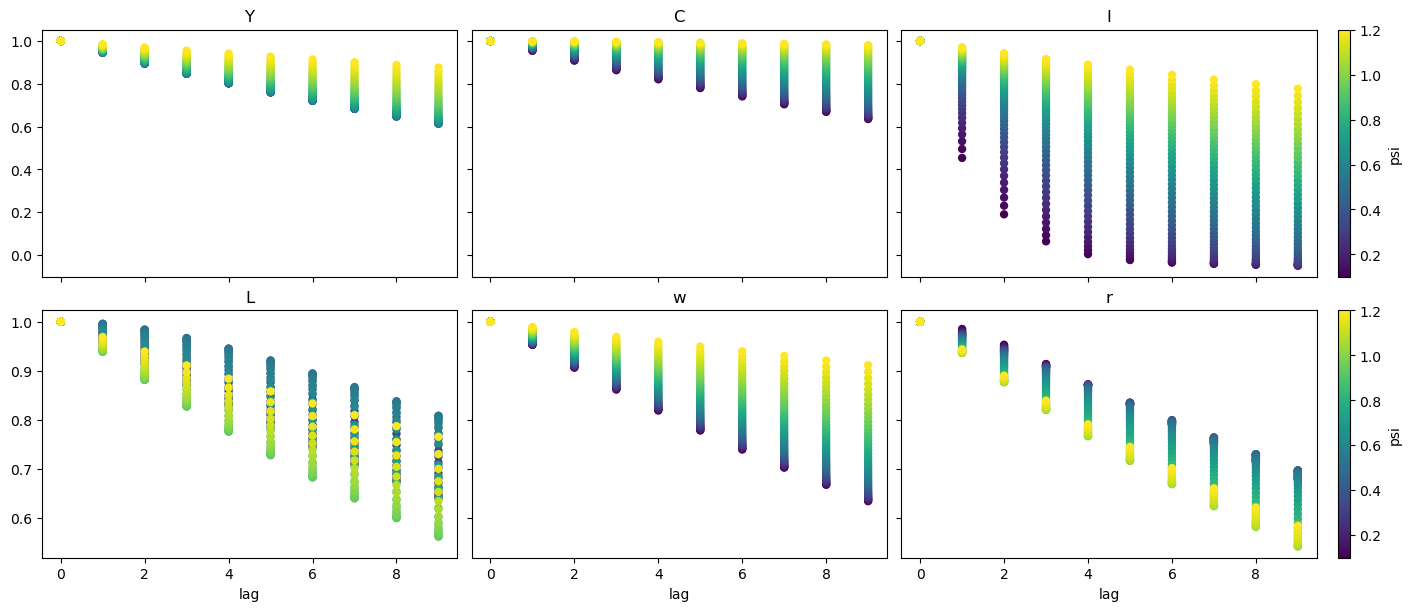

In [25]:
fig, ax = plt.subplots(
    2, 3, figsize=(14, 6), layout="constrained", sharex=True, sharey="row"
)
for axis, variable in zip(fig.axes, ["Y", "C", "I", "L", "w", "r"]):
    acorr_mats.sel(variable=variable).plot.scatter(
        x="lag",
        hue="psi",
        add_legend=False,
        add_colorbar=axis in ax[:, -1],
        cmap="viridis",
        edgecolor="none",
        ax=axis,
    )
    axis.set(title=variable, xlabel="lag" if axis in ax[-1, :] else "")

plt.show()

## Finding the regime switch

To find where the regime switch happens, we can solve the model for different values of $\psi$ and look at the effect of the shocks and state variabels on $L$.

In [26]:
Ts, Rs = [], []
for psi in psis:
    T, R = mod_ces.solve_model(verbose=False, psi=psi)
    Ts.append(
        ge.matrix_to_dataframe(T, mod_ces)[["A", "K"]]
        .to_xarray()
        .expand_dims("psi")
        .assign_coords(psi=[psi])
    )
    Rs.append(
        ge.matrix_to_dataframe(R, mod_ces)
        .to_xarray()
        .expand_dims("psi")
        .assign_coords(psi=[psi])
    )

In [27]:
Ts = xr.concat(Ts, "psi")
Rs = xr.concat(Rs, "psi")

From these, plots we can see the inflection in the effect of shocks on $L$ happens around 0.5. I have no idea what specifically happens at that value to induce the regime change. If we were interested in chasing down the answer to this question, a good next step would be to check out the linearized equations. This notebook is getting long enough, though, so I'll cut it off here.

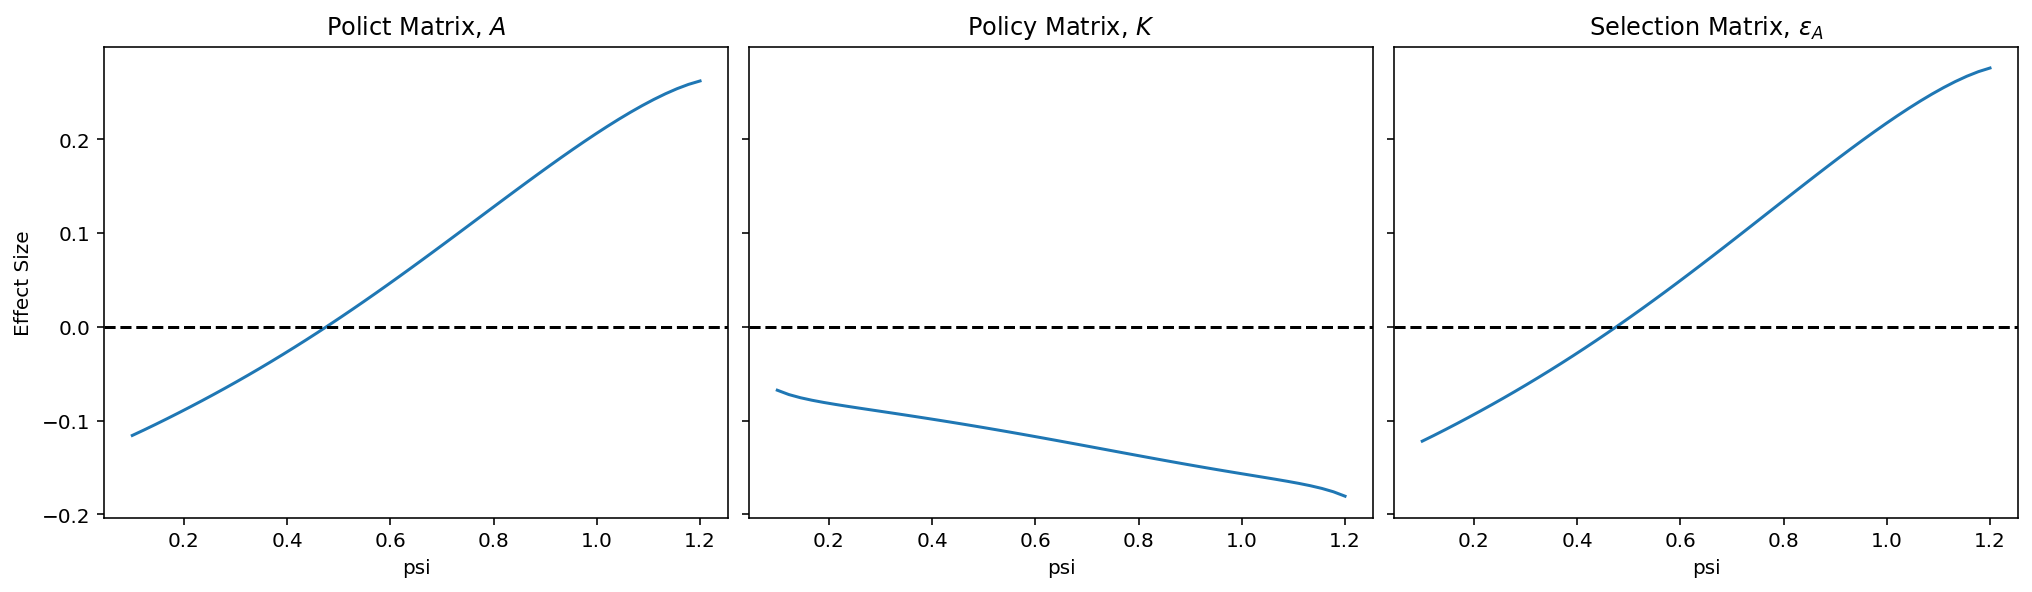

In [28]:
fig, ax = plt.subplots(
    1, 3, figsize=(14, 4), dpi=144, layout="constrained", sharey=True
)
datas = [Ts.A, Ts.K, Rs.epsilon_A]
names = [
    r"Polict Matrix, $A$",
    r"Policy Matrix, $K$",
    r"Selection Matrix, $\varepsilon_A$",
]
for axis, data, name in zip(fig.axes, datas, names):
    data.sel(index="L").plot(ax=axis)
    axis.set(title=name, ylabel="Effect Size" if axis == ax[0] else "")
    axis.axhline(0, ls="--", c="k")

Let's pin down an exact value for the inflection point by using interpolation to get a smooth function, then using `root_minimize` to find the zero.

Looks like the precise value is 0.475

In [29]:
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

y = Ts.A.sel(index="L").values
f = interp1d(psis, y, kind="cubic")

root = root_scalar(f, bracket=[0.4, 0.6])
root

      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: 0.4757723932990602
         method: brentq

We can take a closer look at the IRFs of $L$, and focus on the inflection point

In [30]:
data = irfs.sel(variable="L", shock="epsilon_A")
irf_zero = ge.impulse_response_function(
    mod_ces, psi=root.root, shock_size={"epsilon_A": 0.1}, verbose=False
)

When $\psi$ is exactly equal to the inflection point, we indeed see that the initial effect of the shock is zero. But after several periods, labor ends up decreasing, before returning to the steady state. This is likely due to the influence of the change in capital stock, which occurs with some lag.

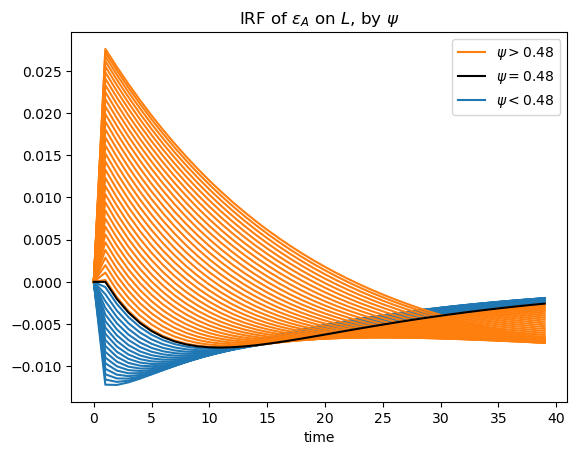

In [31]:
fig, ax = plt.subplots()

data.where(data.psi < root.root).plot.line(
    x="time", hue="psi", add_legend=False, ax=ax, color="tab:blue"
)
data.where(data.psi > root.root).plot.line(
    x="time", hue="psi", add_legend=False, ax=ax, color="tab:orange"
)
irf_zero.sel(variable="L", shock="epsilon_A").plot.line(
    x="time", color="k", add_legend=False
)
ax.set_title(r"IRF of $\varepsilon_A$ on $L$, by $\psi$")

lines = ax.get_lines()
orange, blue, black = lines[-2], lines[0], lines[-1]
ax.legend(
    [orange, black, blue],
    [
        r"$\psi > {:0.2f}$".format(root.root),
        r"$\psi = {:0.2f}$".format(root.root),
        r"$\psi < {:0.2f}$".format(root.root),
    ],
)
plt.show()

# Authors

- Created by Jesse Grabowski, March 4, 2025

# Watermark

In [32]:
# Lambdified functions break watermark; need to delete them
del f, f1, f2, f3, f_cd, f_ces, f_min, f_Q, f_Q_cd

In [33]:
%load_ext watermark
%watermark -n -u -v -w -m -iv

Last updated: Tue Mar 04 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.1

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

sympy          : 1.12.1
cycler         : 0.12.1
gEconpy        : 0+untagged.305.gd931e48.dirty
xarray         : 2025.1.2
xarray_einstats: 0.8.0
matplotlib     : 3.10.1
pandas         : 2.2.3
scipy          : 1.12.0
numpy          : 1.26.4

Watermark: 2.5.0

